# Prophetのパラメータ
Prophetにどのようなパラメータがあるか整理します。

```{warning}
このページは書きかけです！！！
```

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if str(get_ipython()).startswith("<google.colab."):
    !pip install japanize_matplotlib
    !pip install prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from prophet import Prophet

In [3]:
# グラフの表示パラメタ
sns.set(
    rc={
        "figure.figsize": (12, 4),
        "legend.fontsize": "large",
        "figure.titlesize": "large",
        "axes.titlesize": 20,
    }
)
japanize_matplotlib.japanize()
np.random.seed(777)

## 実験に使用するデータ

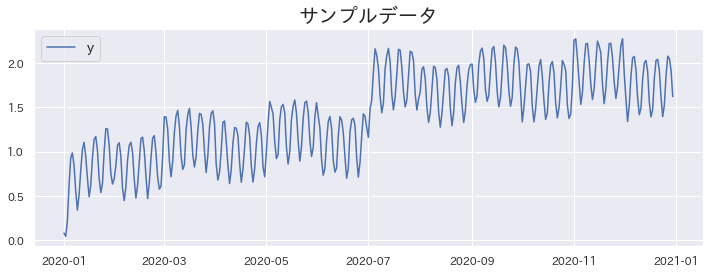

In [4]:
date = pd.date_range("2020-01-01", periods=365, freq="D")

# 予測対象
y = [
    np.cos(di.weekday()) / 3
    + di.month % 2 / 5
    + np.log(i + 1) / 5.0
    + (i > 182) * 0.5
    + np.random.rand() / 10
    for i, di in enumerate(date)
]

# トレンド成分
x = [18627 + i - 364 for i in range(365)]
trend_y = [np.log(i + 1) / 3.0 for i, di in enumerate(date)]
weekly_y = [np.cos(di.weekday()) for i, di in enumerate(date)]
seasonal_y = [di.month % 2 / 2 for i, di in enumerate(date)]
noise_y = [np.random.rand() / 10 for i in range(365)]

df = pd.DataFrame({"ds": date, "y": y})
df.index = date

# 実験に使用するデータ
plt.title("サンプルデータ")
sns.lineplot(data=df)
plt.show()

## growthパラメータ
### growth="linear"とした場合の予測

Initial log joint probability = -16.6231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       792.152    0.00138864       97.2266   2.443e-05       0.001      145  LS failed, Hessian reset 
      99       792.228   7.40168e-07       55.8404     0.03797     0.03797      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       792.388   3.51776e-05       59.7965    6.64e-07       0.001      263  LS failed, Hessian reset 
     199        792.62    3.0252e-05       72.8985      0.4243           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       792.799   0.000165183       55.2724   3.174e-06       0.001      440  LS failed, Hessian reset 
     299       792.972   0.000162358       62.7075           1           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

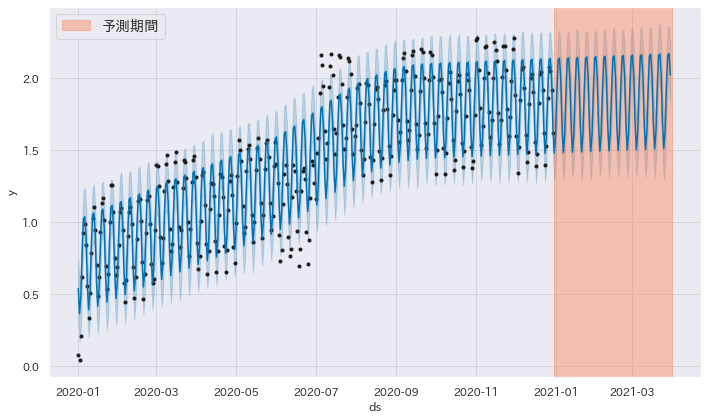

In [5]:
# モデルを訓練
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    growth="linear",
)
m.fit(df)

# 将来を予測
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.axvspan(18627, 18627 + 90, color="coral", alpha=0.4, label="予測期間")
plt.legend()
plt.show()

### growth="linear"で表現できるトレンド成分
growth="linear"でどのようなトレンドを表現できるか確認してみます。 `linear_trend` はprophetで `growth="linear"`　を指定した時にトレンド作成に使用するコードを再現してみます。

※参考文献のコードと記号を合わせました、ミスがある場合はお手数ですがissueに指摘いただけると大変助かります

```{admonition} 参考文献
[prophet/R/inst/stan/prophet.stan](https://github.com/facebook/prophet/blob/ba9a5a2c6e2400206017a5ddfd71f5042da9f65b/R/inst/stan/prophet.stan#L64-L82)
```

```{note}
$A$の各行の次元数は変化点の数です。また、各次元の値は

$ a_j(t) \left\{ \begin{array}{ll} 1, & \text{if}　\ t \ge s_j \\ 0, & \text{otherwise} \end{array} \right. $

となっています。時刻$t$の$a$の$j$次元目は、$t$が$j$番目の変化点よりあとの時刻ならば$1$になる、ということです。
```

In [6]:
def linear_trend(
    k: float, m: float, delta: np.array, t: np.array, t_change: list
) -> np.array:
    """線形トレンドを作成する

    Args:
        k (float): 係数
        m (float): 係数
        delta (np.array): delta
        t (np.array): タイムスタンプ
        t_change (list): トレンド変化点

    Returns:
        np.array: トレンド
    """
    A = np.vstack([np.where(t_change < ti, 1, 0) for ti in t])
    return (k + (A * delta).sum(axis=1)) * t + (
        m + (A * (-t_change * delta)).sum(axis=1)
    )

### `linear_trend`で表現できるトレンドを可視化する

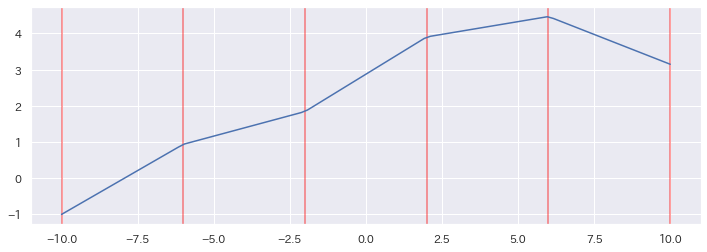

In [7]:
# 適当にトレンドのような線を作成するため、変化点の数と各区間での線の傾きを指定します
change_point_num = 5
t = np.linspace(-10, 10, 100)
t_change = np.linspace(-10, 10, change_point_num + 1)
delta = np.array([np.random.rand() - 0.5 for _ in range(change_point_num + 1)])

# linear_trendで線を引く
trend_y = linear_trend(0.1, 0, delta, t, t_change)

# できた線をプロットしてみる
[plt.axvline(x=tci, color="red", alpha=0.5) for tci in t_change]  # 変化点をプロット
plt.plot(t, trend_y)
plt.show()